In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from itertools import product
from tqdm import tqdm

import torch 
import torch.nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import TensorDataset, DataLoader

import tenseal as ts
import random
import time
import pickle

from sklearn.metrics import auc,roc_auc_score,log_loss,f1_score,brier_score_loss,precision_recall_curve

#os.path.realpath(__file__)
#main_path = os.getcwd()
main_path = 'C:\\Users\\Fabian\\Desktop\\Studium\\2.) HU Berlin\\6.) SS_21\\Master Thesis\\Federated Learning for Credit Risk\\Submission_Folder'

sys.path.append(main_path + '\\code\\modules')

from feature_gen import *
from nonfed_models import *
from hfed_models import *
from hc_fun import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.4f}'.format


input_path = main_path + '\\cleaned_datasets\\'
model_path =  main_path + '\\models\\'
result_path =  main_path + '\\results\\'
plot_path = main_path + '\\results\\Plot Data\\'
param_path = main_path + '\\results\\Non-FL Results\\Best Params Horizontal\\'

# Load config
with open(main_path + '/config_general.yml','r') as f:
    config = yaml.safe_load(f)

In [2]:
# Extract data
bs = [350,700,1400]
mod = ['lg','NN']
mod_type = ['WOA','FedAvg']
data_type = ['iid','noniid']
inp_list = [bs,mod,mod_type,data_type]

combis = list(product(*inp_list))

data_list_m2 = []
data_list_m3 = []

for c in combis:
    with open(plot_path + f'bs{c[0]}_h{c[1]}_trainer_{c[2]}_{c[3]}.pickle','rb') as handle:
        tmp = pickle.load(handle)
    
    m2_epoch_list = []
    for val in tmp['m2'].values():
        m2_epoch_list.extend(val)
    
    m3_epoch_list = []
    for val in tmp['m3'].values():
        m3_epoch_list.extend(val)
    
    m2_data = pd.DataFrame({'client':'m2','Batch Size':c[0],'model':c[1],'Model Type':c[2],'data_dist':c[3],'loss':m2_epoch_list})
    data_list_m2.append(m2_data)
    
    m3_data = pd.DataFrame({'client':'m3','Batch Size':c[0],'model':c[1],'Model Type':c[2],'data_dist':c[3],'loss':m3_epoch_list})
    data_list_m3.append(m3_data)
    
df_m2 = pd.concat(data_list_m2,axis=0)
df_m3 = pd.concat(data_list_m3,axis=0)

df = pd.concat([df_m2,df_m3],axis=0)


# Prepare final format for plots
combis = list(product(['m2','m3'],data_type))

data_lg = {}
data_nn = {}

for c in combis:
    data_lg[c[0]] = {
        c[1]:df.loc[(df['model']=='lg') & (df['client']==c[0]) & (df['data_dist']==c[1]), :]
    }
    
    data_nn[c[0]] = {
        c[1]:df.loc[(df['model']=='NN') & (df['client']==c[0]) & (df['data_dist']==c[1]), :]
    }
    

In [3]:

clients = ['m2','m3']
ddist = ['iid','noniid']

data_lg = {c:{} for c in clients} 
data_nn = {c:{} for c in clients}

for c in clients:
    for d in ddist:
        # Logistic Regression data
        tmp = df.loc[(df['model']=='lg') & (df['client']==c) & (df['data_dist']==d), :].reset_index()
        max_rows = tmp.groupby('Batch Size')['index'].max().min()

        tmp = tmp.loc[tmp['index']<=max_rows,:]
        data_lg[c][d] = tmp

        # Neural Network data
        tmp = df.loc[(df['model']=='NN') & (df['client']==c) & (df['data_dist']==d), :].reset_index()
        max_rows = tmp.groupby('Batch Size')['index'].max().min()

        tmp = tmp.loc[tmp['index']<=max_rows,:]
        data_nn[c][d] = tmp
            

In [4]:
def progress_plot(data,fsize=(16,10),bsizes=[700,1400],colors=['red','blue','orange','green'],save=False,save_path=None,file_name=None):
    colors = np.array(colors)
    idx = int(len(colors)/2)
    
    xticks = []
    for i in np.unique(data['m2']['iid']['index']):
        if i % 10 == 0:
            xticks.append(i)
            
    # lg iid
    tmp1 = data['m2']['iid']
    tmp1 = tmp1.loc[tmp1['Batch Size'].isin(bsizes),:]
    tmp2 = data['m2']['noniid']
    tmp2 = tmp2.loc[tmp2['Batch Size'].isin(bsizes),:]

    tmp3 = data['m3']['iid']
    tmp3 = tmp3.loc[tmp3['Batch Size'].isin(bsizes),:]
    tmp4 = data['m3']['noniid']
    tmp4 = tmp4.loc[tmp4['Batch Size'].isin(bsizes),:]

    sns.set_style('dark')
    fig,ax = plt.subplots(2,2,figsize=fsize,sharey='row')
    sns.set_style('white')
    sns.lineplot(
        data=tmp1,x='index',y='loss',hue='Batch Size',style='Model Type',ax=ax[0,0],palette = list(colors[:idx])
    )
    ax[0,0].set_title(r"$\bf{IID}$",fontsize=16)
    ax[0,0].set_ylabel(r"$\bf{Client 2}$" + "\n Log-Loss",fontsize=14)
    ax[0,0].tick_params(axis='y',labelsize=13)
    ax[0,0].set_xlabel(None)
    ax[0,0].set_xticks(xticks)
    ax[0,0].set_xticklabels(xticks,fontsize=13)
    ax[0,0].legend(loc='upper right',prop={'size': 14},ncol=2)

    sns.lineplot(
        data=tmp2,x='index',y='loss',hue='Batch Size',style='Model Type',ax=ax[0,1],palette = list(colors[:idx])
    )
    ax[0,1].set_title(r"$\bf{Non-IID}$",fontsize=16)
    ax[0,1].set_xlabel(None)
    ax[0,1].set_xticks(xticks)
    ax[0,1].set_xticklabels(xticks,fontsize=13)
    ax[0,1].legend(loc='upper right',prop={'size': 14},ncol=2)

    sns.lineplot(
        data=tmp3,x='index',y='loss',hue='Batch Size',style='Model Type',ax=ax[1,0],palette = list(colors[idx:])
    )
    ax[1,0].set_ylabel(r"$\bf{Client 3}$" + "\n Log-Loss",fontsize=14)
    ax[1,0].tick_params(axis='y',labelsize=13)
    ax[1,0].set_xlabel("Number of Batches",fontsize=16)
    ax[1,0].tick_params(axis='x',labelsize=13)
    ax[1,0].legend(loc='upper right',prop={'size': 14},ncol=2)

    sns.lineplot(
        data=tmp4,x='index',y='loss',hue='Batch Size',style='Model Type',ax=ax[1,1],palette = list(colors[idx:])
    )
    ax[1,1].set_xlabel("Number of Batches",fontsize=16)
    ax[1,1].tick_params(axis='x',labelsize=13)
    ax[1,1].legend(loc='upper right',prop={'size': 14},ncol=2)

    plt.tight_layout()
    if save == True:
        plt.savefig(save_path + file_name + '.png')
 
    plt.show()

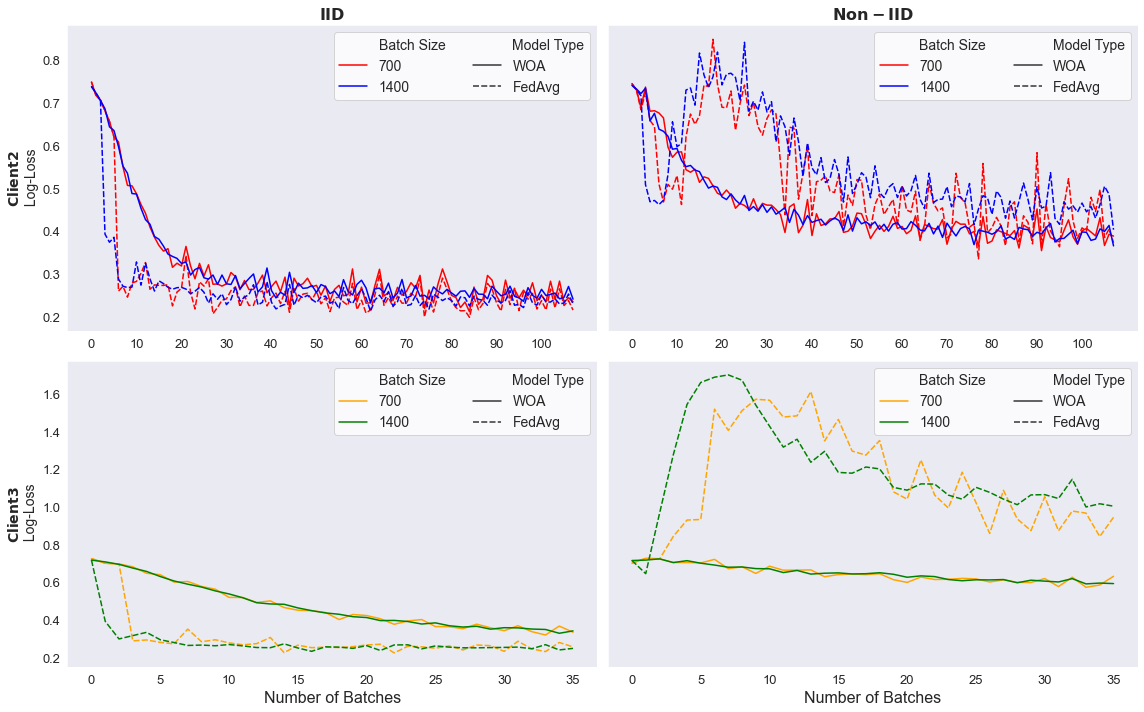

In [5]:
arg_dict = {
    'data':data_lg,
    'fsize':(16,10),
    'bsizes':[700,1400],
    'colors':['red','blue','orange','green'], # lime & purple for plot with three lines
    'save':False,
    'save_path':result_path,
    'file_name': "progress_plot_lg2"
}
progress_plot(**arg_dict)

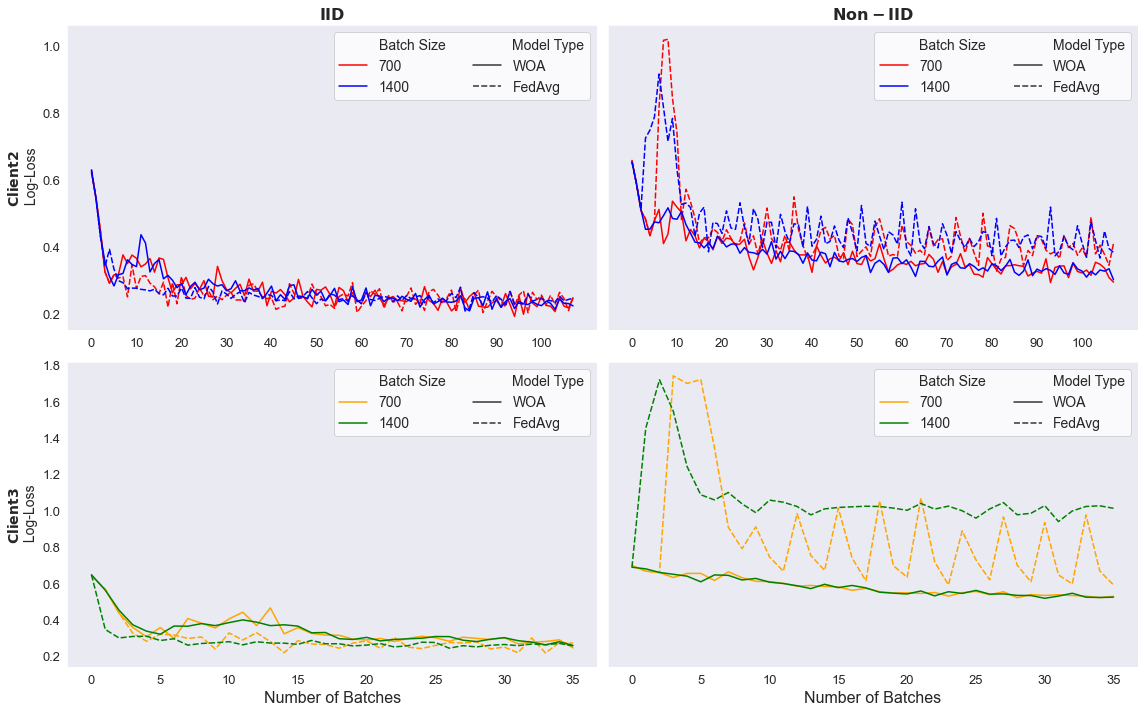

In [6]:
arg_dict = {
    'data':data_nn,
    'fsize':(16,10),
    'bsizes':[700,1400],
    'colors':['red','blue','orange','green'],
    'save':False,
    'save_path':result_path,
    'file_name':"progress_plot_nn2"
}
progress_plot(**arg_dict)